<a href="https://colab.research.google.com/github/minsu1206/OCRdistill/blob/main/0202_dataload%2BCharNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/!YAI_OCRdistill

/content/drive/MyDrive/!YAI_OCRdistill


In [3]:
!pwd

/content/drive/MyDrive/!YAI_OCRdistill


#### dataload.py, visualize.py 실행

In [4]:
import imgaug
print(imgaug.__file__) 
print(imgaug.__version__)

/usr/local/lib/python3.7/dist-packages/imgaug/__init__.py
0.4.0


In [ ]:
!pip uninstall imgaug

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9


In [ ]:
!pip install imgaug

     |████████████████████████████████| 948 kB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
#!pip install opencv-python-headless==4.1.2.30

In [ ]:
import imgaug
print(imgaug.__file__) 
print(imgaug.__version__)

/usr/local/lib/python3.7/dist-packages/imgaug/__init__.py
0.2.9


1000
1000
<class 'numpy.ndarray'> (640, 640, 3)


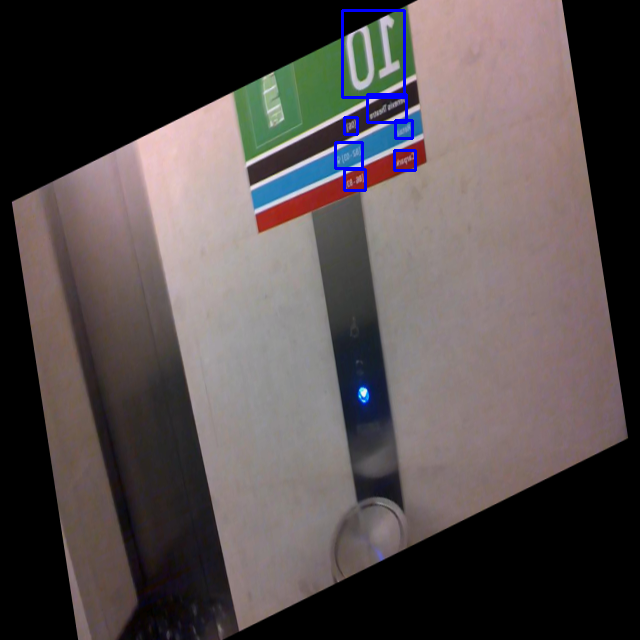

This is index : 0
This is Img Tensor :  <class 'torch.Tensor'> torch.Size([4, 3, 640, 640])
This is Label Tensor :  4 torch.Size([8, 4]) torch.Size([7, 4]) torch.Size([8, 4]) torch.Size([83, 4])


In [5]:
"""
ICDAR 2015 - Text Localisation task dataset
: 1000 images, 1000 annotation files
Code Reference :
    (1) https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    (2) https://imgaug.readthedocs.io/en/latest/source/examples_bounding_boxes.html
Requirements:
    - torch
    - torchvision
    - imgaug
    by MS.KIM
"""

import enum
import torch
import os
import torchvision
from torch.utils.data import Dataset
# from torchvision.io import read_image
import cv2
import torchvision.transforms as transforms
import glob
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

#import cv2
import numpy as np

from google.colab.patches import cv2_imshow

class Augment:
    def __init__(self, img_size, to_tensor=True):
        self.img_size = img_size
        self.seq = iaa.Sequential([
            iaa.MultiplyAndAddToBrightness(mul=(0.8, 1.2), add=(-30, 30)),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(scale={"x":(0.8, 1.2), "y":(0.8, 1.2)}),
            iaa.Affine(rotate=(-15, 15)),
            iaa.Affine(shear=(-15, 15)),
            iaa.Resize((self.img_size[0], self.img_size[1]))
        ])
        self.to_tensor = True
        self.compose = transforms.Compose([transforms.ToTensor()])

    def aug(self, image, points: list):
        bboxes = self.poly2bbox(points)
        shape = image.shape[:2]
        bboxes_ia = self.bbox_list2ia(shape, bboxes)
        image_aug, bbox_aug = self.seq(image=image, bounding_boxes=bboxes_ia)
        if self.to_tensor:
            image_aug = self.img_ia2tensor(image_aug)
            bbox_aug = self.bbox_ia2tensor(bbox_aug)
        return image_aug, bbox_aug

    @staticmethod
    def bbox_list2ia(shape, bbox: list):
        # convert Variable:bbox from List[List[], List[], ... ] to Imgaug BoundingBoxes.
        img_bbox = []
        for bbox_ in bbox:
            img_bbox.append(BoundingBox(x1=bbox_[0], y1=bbox_[1], x2=bbox_[2], y2=bbox_[3]))
        return BoundingBoxesOnImage(img_bbox, shape=shape)

    @staticmethod
    def poly2bbox(points_list):
        # convert points(polygon) to standard bounding box format
        bboxes = []
        for points in points_list:
            xs = [points[2*idx] for idx in range(4)]
            ys = [points[2*idx+1] for idx in range(4)]
            top_left_x = min(xs)
            top_left_y = min(ys)
            bottome_right_x = max(xs)
            bottome_right_y = max(ys)
            bboxes.append([top_left_x, top_left_y, bottome_right_x, bottome_right_y])
        return bboxes

    @staticmethod
    def bbox_ia2tensor(bbox_ia):
        temp = []
        for i in range(len(bbox_ia)):
            box_coords = bbox_ia.bounding_boxes[i]
            temp.append([box_coords.x1, box_coords.y1, box_coords.x2, box_coords.y2])
        return torch.tensor(temp).reshape(-1, 4)

    def img_ia2tensor(self, img_ia):
        img = self.compose(img_ia)
        return img


class ICDAR_Dataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform):
        """
        img_dir : path of directory containing images
        annotation_dir : path of directory containing annotation files (ICDAR2015 : .txt files)
        transform : Augment Class Instance
        """

        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = sorted(glob.glob(self.img_dir + '/*.jpg'), key=lambda x: int(x.split('img_')[-1].split('.')[0]))
        self.file_names = sorted(glob.glob(self.annotation_dir + '/*.txt'), key=lambda x: int(x.split('img_')[-1].split('.')[0]))
        print(len(self.img_names))
        print(len(self.file_names))
        assert len(self.img_names) == len(self.file_names), "# of images and # of annotations must be same."

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.img_names[idx]
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        with open(self.file_names[idx], 'r', encoding='utf-8-sig') as f:
            txt_lines = f.readlines()
            label = []
            for line in txt_lines:
                one_word = []
                vals = line.split(',')
                # print(type(vals[0]), vals[0])
                # if 'ff' in vals[0]:
                #     print('vals[0]', vals[0])
                #     vals[0] = vals[0][6:]

                for val in vals[:-1]:
                    one_word.append(int(float(val)))
                label.append(one_word)

        image_aug, label_aug = self.transform.aug(image, label)
        return image_aug, label_aug

    @staticmethod
    def collate_fn(batch):
        """
        Each bbox label has different shape (N, 4) (because each image has different # of objects)
        """
        images = []
        box_labels = []
        for b in batch:
            images.append(b[0])
            box_labels.append(b[1])
        
        images = torch.stack(images, dim=0)
        return images, box_labels

def bbox_visualize(img, bbox):
    """
    img : image ndarray
    bbox : List[List(top-left-x, top-left-y, bottom-right-x, bottom-right-y), List(), ...] or
            Torch.Tensor([List(top-left-x, top-left-y, bottom-right-x, bottom-right-y), List(), ...])
    Return
        Visualized bbox
    """
    # img = np.uint8(img).copy()
    print(type(img), img.shape)
    color = (255, 0, 0)
    thickness = 2
    for one_box in bbox:
        start_point = (int(one_box[0]), int(one_box[1]))
        end_point = (int(one_box[2]), int(one_box[3]))
        img = cv2.rectangle(img, start_point, end_point, color, thickness)
    
    return img

if __name__ == '__main__':
    """
    
    How to use "ICDAR_Dataset" & "Augment" ?
    EX)
    """
    # dataset download : https://rrc.cvc.uab.es/?ch=4&com=downloads
    target_img_size = (640, 640)
    custom_augment = Augment(img_size=target_img_size)
    custom_dataset = ICDAR_Dataset(img_dir='/content/drive/MyDrive/!YAI_OCRdistill/ch4_training_images',
                                   annotation_dir='/content/drive/MyDrive/!YAI_OCRdistill/ch4_training_localization_transcription_gt',
                                   transform=custom_augment)

    one_img, one_label = custom_dataset[0]
    
    # Visualize Test
    import numpy as np
    #from visualize import bbox_visualize
    one_img = np.array(one_img) * 255
    one_img = np.transpose(one_img, (1, 2, 0)).astype(np.uint8).copy()

    vis_img = bbox_visualize(one_img, one_label)
    cv2_imshow(vis_img)
    cv2.waitKey(0)

    # Dataloader
    from torch.utils.data import DataLoader

    custom_dataloader = DataLoader(custom_dataset, batch_size=4, shuffle=True, collate_fn=custom_dataset.collate_fn)

    for i, (img, label) in enumerate(custom_dataloader):
        print("This is index :", i)
        print("This is Img Tensor : ", type(img), img.shape)
        print("This is Label Tensor : ", len(label), label[0].shape, label[1].shape, label[2].shape, label[3].shape)

        break
    #print(one_img, one_label)

___

___

#### charnet 결과 출력

In [6]:
cd /content/drive/MyDrive/연대/YAI/2022산학협력/code/charnet_view/

/content/drive/MyDrive/연대/YAI/2022산학협력/code/charnet_view


In [7]:
cd research-charnet

/content/drive/MyDrive/연대/YAI/2022산학협력/code/charnet_view/research-charnet


In [8]:
!pip install torch torchvision pyclipper yacs > /dev/null 2>&1
!python setup.py build develop > /dev/null 2>&1
!bash download_weights.sh > /dev/null 2>&1

In [9]:
!mkdir image_dir
!mkdir result_dir

mkdir: cannot create directory ‘image_dir’: File exists
mkdir: cannot create directory ‘result_dir’: File exists


In [10]:
!python tools/test_net.py configs/icdar2015_hourglass88.yaml image_dir result_dir

CHAR_DICT_FILE: datasets/ICDAR2015/test/char_dict.txt
CHAR_MIN_SCORE: 0.25
CHAR_NMS_IOU_THRESH: 0.3
CHAR_STRIDE: 4
INPUT_SIZE: 2280
MAGNITUDE_THRESH: 0.2
NUM_CHAR_CLASSES: 68
RESULTS_SEPARATOR: ,
SIZE_DIVISIBILITY: 128
WEIGHT: weights/icdar2015_hourglass88.pth
WORD_DETECTOR_DILATION: 1
WORD_LEXICON_PATH: datasets/ICDAR2015/test/GenericVocabulary.txt
WORD_MIN_SCORE: 0.95
WORD_NMS_IOU_THRESH: 0.15
WORD_STRIDE: 4
Processing img_1.jpg...
Processing img_2.jpg...
Processing img_3.jpg...
Processing img_4.jpg...
Processing img_5.jpg...


image_dir/img_1.jpg result_dir/img_1.txt
CARPARK
373
GENAXIS
372
B3]
519
THEATRE
418
[06]
492


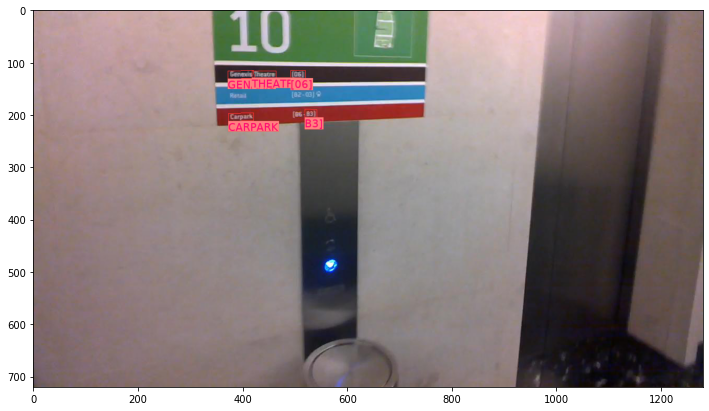

image_dir/img_2.jpg result_dir/img_2.txt
EXIT
602
I2R
736


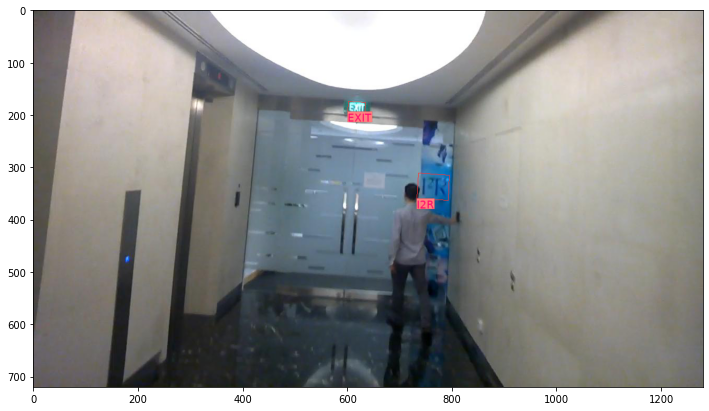

image_dir/img_3.jpg result_dir/img_3.txt
FUSIONOPOLIS
56


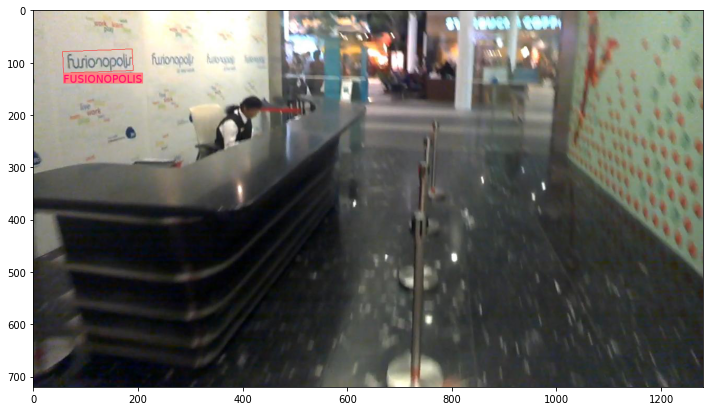

image_dir/img_4.jpg result_dir/img_4.txt
TRAIN
667
SAP
704


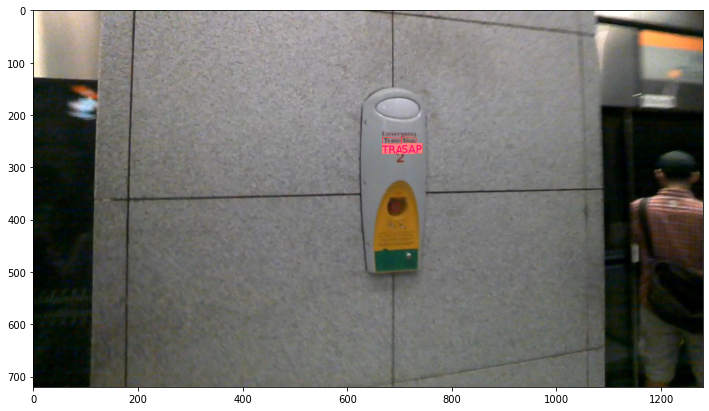

image_dir/img_5.jpg result_dir/img_5.txt


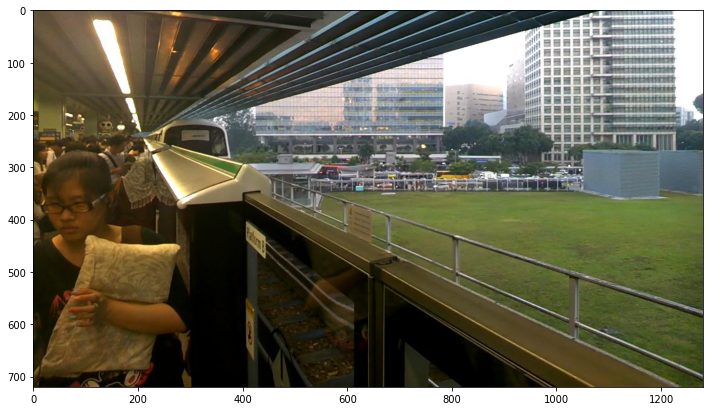

In [11]:
from PIL import Image, ImageDraw, ImageFont
from glob import glob
import matplotlib.pyplot as plt

input_paths = glob('image_dir/*')
input_paths.sort()
result_paths = glob('result_dir/*.txt')
result_paths.sort()

for input_path, result_path in zip(input_paths, result_paths):
  print(input_path, result_path)
  image = Image.open(input_path).convert('RGBA')
  draw = ImageDraw.Draw(image)
  font = ImageFont.truetype(
      '/content/drive/MyDrive/연대/YAI/2022산학협력/code/charnet_view/DejaVuSans.ttf', 20)

  with open(result_path) as f:
    lines = f.readlines()
  
  for line in lines:
    factors = line.strip().split(',')
    coords = list(map(int, factors[:-1]))
    label = factors[-1]
    print(label) ### output 출력!!
    print(factors[0])
    draw.polygon(
        [tuple(coords[0:2]), tuple(coords[2:4]), tuple(coords[4:6]), tuple(coords[6:8])], 
        outline=(255,0,0,200)
    )
    fs = font.getsize(label)
    c = coords[6], coords[7], coords[6] + fs[0], coords[7] + fs[1]
    draw.rectangle(c, fill=(255,0,0, 127))
    draw.text(tuple(coords[6:8]), label, fill=(255,0,127), font=font)

  plt.figure(figsize=(12,16))
  plt.imshow(image)
  image.save(result_path.replace('txt', 'png'))
  plt.show()

___

#### txt 파일 결과 다 출력해봄

In [12]:
!mkdir gtt_dir

mkdir: cannot create directory ‘gtt_dir’: File exists


In [13]:
gtt_paths = glob('gtt_dir/*.txt')
gtt_paths.sort()
print(gtt_paths)

['gtt_dir/gt_img_1.txt', 'gtt_dir/gt_img_2.txt', 'gtt_dir/gt_img_3.txt', 'gtt_dir/gt_img_4.txt', 'gtt_dir/gt_img_5.txt']


In [14]:
import re

for input_path, result_path, gtt_path in zip(input_paths, result_paths, gtt_paths):
  print(input_path, result_path, gtt_path)
  image = Image.open(input_path).convert('RGBA')
  draw = ImageDraw.Draw(image)
  font = ImageFont.truetype(
      '/content/drive/MyDrive/연대/YAI/2022산학협력/code/charnet_view/DejaVuSans.ttf', 20)

  with open(result_path) as f:
    lines = f.readlines()
  
  pred_coord = []
  pred_word = []
  for line in lines:
    factors = line.strip().split(',')
    coords = list(map(int, factors[:-1]))
    label = factors[-1]
    #print(label) ### output 출력!!
    #print(factors[0])
    pred_coord.append(coords)
    pred_word.append(label)
    draw.polygon(
        [tuple(coords[0:2]), tuple(coords[2:4]), tuple(coords[4:6]), tuple(coords[6:8])], 
        outline=(255,0,0,200)
    )
  print('pred_coord :', pred_coord)
  print('pred_word :', pred_word)

  with open(gtt_path) as f:
    gtt_lines = f.readlines()
  
  gtt_coord = []
  gtt_word = []
  for line in gtt_lines:
    factors = line.strip().split(',')
    factors[0] = re.findall(r'\d+', factors[0])
    factors[0] = "".join(factors[0])
    #print(type(factors[0]))
    #print(factors)
    coords = list(map(int, factors[:-1]))
    label = factors[-1]
    
    #print(label) ### output 출력!!
    #print(factors[0])
    gtt_coord.append(coords)
    gtt_word.append(label)
    #draw.polygon(
    #    [tuple(coords[0:2]), tuple(coords[2:4]), tuple(coords[4:6]), tuple(coords[6:8])], 
    #    outline=(255,0,0,200)
    #)
  print('gtt_coord :', gtt_coord)
  print('gtt_word :', gtt_word)
  print('\n')

  

image_dir/img_1.jpg result_dir/img_1.txt gtt_dir/gt_img_1.txt
pred_coord : [[373, 197, 421, 196, 421, 211, 373, 212], [372, 116, 421, 115, 422, 130, 372, 131], [519, 189, 542, 190, 542, 205, 519, 205], [418, 116, 464, 116, 464, 130, 418, 129], [492, 115, 520, 115, 520, 131, 492, 130]]
pred_word : ['CARPARK', 'GENAXIS', 'B3]', 'THEATRE', '[06]']
gtt_coord : [[377, 117, 463, 117, 465, 130, 378, 130], [493, 115, 519, 115, 519, 131, 493, 131], [374, 155, 409, 155, 409, 170, 374, 170], [492, 151, 551, 151, 551, 170, 492, 170], [376, 198, 422, 198, 422, 212, 376, 212], [494, 190, 539, 189, 539, 205, 494, 206], [374, 1, 494, 0, 492, 85, 372, 86]]
gtt_word : ['Genaxis Theatre', '[06]', '###', '62-03', 'Carpark', '###', '###']


image_dir/img_2.jpg result_dir/img_2.txt gtt_dir/gt_img_2.txt
pred_coord : [[602, 174, 635, 176, 634, 196, 601, 194], [736, 311, 795, 315, 793, 363, 733, 360]]
pred_word : ['EXIT', 'I2R']
gtt_coord : [[602, 173, 635, 175, 634, 197, 602, 196], [734, 310, 792, 320, 792, 3

#### gtt파일 띄어쓰기, - 단위로 나누기

In [16]:
def divide_word(coords, label):
  coords_div = []
  label_div = []
  blank_ck = 0
  coords_cut = coords.copy()
  for i in range(len(label)):
    if (label[i] == ' ') or (label[i] == '-'):
      a = coords[0] + (coords[2]-coords[0])*i/len(label)
      b = coords[1] + (coords[3]-coords[1])*i/len(label)
      c = coords[6] + (coords[4]-coords[6])*i/len(label)
      d = coords[7] + (coords[5]-coords[7])*i/len(label)
      e = coords[0] + (coords[2]-coords[0])*(i+1)/len(label)
      f = coords[1] + (coords[3]-coords[1])*(i+1)/len(label)
      g = coords[6] + (coords[4]-coords[6])*(i+1)/len(label)
      h = coords[7] + (coords[5]-coords[7])*(i+1)/len(label)
      coords_put = [coords_cut[0], coords_cut[1], a, b, c, d, coords_cut[6], coords_cut[7]]
      coords_cut = [e, f, coords_cut[2], coords_cut[3], coords_cut[4], coords_cut[5], g, h]
      coords_div.append(coords_put)
      label_div.append(label[blank_ck:i])
      blank_ck = i+1
    elif i == len(label)-1:
      coords_div.append(coords_cut)
      label_div.append(label[blank_ck:len(label)])
      
  return coords_div, label_div

In [17]:
import re

for input_path, result_path, gtt_path in zip(input_paths, result_paths, gtt_paths):
  print(input_path, result_path, gtt_path)
  image = Image.open(input_path).convert('RGBA')
  draw = ImageDraw.Draw(image)
  font = ImageFont.truetype(
      '/content/drive/MyDrive/연대/YAI/2022산학협력/code/charnet_view/DejaVuSans.ttf', 20)

  with open(result_path) as f:
    lines = f.readlines()
  
  pred_coord = []
  pred_word = []
  for line in lines:
    factors = line.strip().split(',')
    coords = list(map(int, factors[:-1]))
    label = factors[-1]
    #print(label) ### output 출력!!
    #print(factors[0])
    pred_coord.append(coords)
    pred_word.append(label)
    draw.polygon(
        [tuple(coords[0:2]), tuple(coords[2:4]), tuple(coords[4:6]), tuple(coords[6:8])], 
        outline=(255,0,0,200)
    )
  print('pred_coord :', pred_coord)
  print('pred_word :', pred_word)

  with open(gtt_path) as f:
    gtt_lines = f.readlines()
  
  gtt_coord = []
  gtt_word = []
  for line in gtt_lines:
    factors = line.strip().split(',')
    factors[0] = re.findall(r'\d+', factors[0])
    factors[0] = "".join(factors[0])
    #print(type(factors[0]))
    #print(factors)
    coords = list(map(int, factors[:-1]))
    label = factors[-1]

    coords_ck, label_ck = divide_word(coords, label)
    
    #print(label) ### output 출력!!
    #print(factors[0])
    gtt_coord = gtt_coord + coords_ck
    gtt_word = gtt_word + label_ck
    #draw.polygon(
    #    [tuple(coords[0:2]), tuple(coords[2:4]), tuple(coords[4:6]), tuple(coords[6:8])], 
    #    outline=(255,0,0,200)
    #)
  print('gtt_coord :', gtt_coord)
  print('gtt_word :', gtt_word)
  print('\n')

  

image_dir/img_1.jpg result_dir/img_1.txt gtt_dir/gt_img_1.txt
pred_coord : [[373, 197, 421, 196, 421, 211, 373, 212], [372, 116, 421, 115, 422, 130, 372, 131], [519, 189, 542, 190, 542, 205, 519, 205], [418, 116, 464, 116, 464, 130, 418, 129], [492, 115, 520, 115, 520, 131, 492, 130]]
pred_word : ['CARPARK', 'GENAXIS', 'B3]', 'THEATRE', '[06]']
gtt_coord : [[377, 117, 417.1333333333333, 117.0, 418.6, 130.0, 378, 130], [422.8666666666667, 117.0, 463, 117, 465, 130, 424.4, 130.0], [493, 115, 519, 115, 519, 131, 493, 131], [374, 155, 409, 155, 409, 170, 374, 170], [492, 151, 515.6, 151.0, 515.6, 170.0, 492, 170], [527.4, 151.0, 551, 151, 551, 170, 527.4, 170.0], [376, 198, 422, 198, 422, 212, 376, 212], [494, 190, 539, 189, 539, 205, 494, 206], [374, 1, 494, 0, 492, 85, 372, 86]]
gtt_word : ['Genaxis', 'Theatre', '[06]', '###', '62', '03', 'Carpark', '###', '###']


image_dir/img_2.jpg result_dir/img_2.txt gtt_dir/gt_img_2.txt
pred_coord : [[602, 174, 635, 176, 634, 196, 601, 194], [736, 

___
___

#### IOU 비교

직사각형이라고 가정 : https://minimin2.tistory.com/144


임의의 사각형이라고 가정 : https://hellbell.tistory.com/34

In [18]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[4] - box1[0] + 1) * (box1[5] - box1[1] + 1)
    box2_area = (box2[4] - box2[0] + 1) * (box2[5] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[4], box2[4])
    y2 = min(box1[5], box2[5])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [19]:
def IoU_maxidx (pred_coord, pred_word, gtt_coord, gtt_word):
  maxidx = []
  for i in range(len(pred_word)):
    IoU_save = []
    for j in range(len(gtt_word)):
      IoU_save.append(IoU(pred_coord[i], gtt_coord[j]))
    max_IoU = max(IoU_save)
    max_idx = IoU_save.index(max_IoU)
    maxidx.append(max_idx)
  return maxidx

테스트 -> 성공

In [20]:
pred_coord1 = [[373, 197, 421, 196, 421, 211, 373, 212], [372, 116, 421, 115, 422, 130, 372, 131], [519, 189, 542, 190, 542, 205, 519, 205], [418, 116, 464, 116, 464, 130, 418, 129], [492, 115, 520, 115, 520, 131, 492, 130]]
pred_word1 = ['CARPARK', 'GENAXIS', 'B3]', 'THEATRE', '[06]']
gtt_coord1 = [[377, 117, 417.1333333333333, 117.0, 418.6, 130.0, 378, 130], [422.8666666666667, 117.0, 463, 117, 465, 130, 424.4, 130.0], [493, 115, 519, 115, 519, 131, 493, 131], [374, 155, 409, 155, 409, 170, 374, 170], [492, 151, 515.6, 151.0, 515.6, 170.0, 492, 170], [527.4, 151.0, 551, 151, 551, 170, 527.4, 170.0], [376, 198, 422, 198, 422, 212, 376, 212], [494, 190, 539, 189, 539, 205, 494, 206], [374, 1, 494, 0, 492, 85, 372, 86]]
gtt_word1 = ['Genaxis', 'Theatre', '[06]', '###', '62', '03', 'Carpark', '###', '###']

pred_coord2 = [[284, 136, 414, 139, 413, 160, 284, 158], [744, 145, 780, 144, 780, 162, 744, 162], [836, 135, 870, 137, 869, 156, 835, 154]]
pred_word2 = ['HARBOURFRONT', 'CC22', 'DATA']
gtt_coord2 = [[261, 138, 284, 140, 279, 158, 260, 158], [288, 138, 417, 140, 416, 161, 290, 157], [743, 145, 779, 146, 780, 163, 746, 163], [783, 129, 831, 132, 833, 155, 785, 153], [831, 133, 870, 135, 874, 156, 835, 155], [159, 205, 230, 204, 231, 218, 159, 219], [785, 158, 856, 158, 860, 178, 787, 179], [1011, 157, 1079, 160, 1076, 173, 1011, 170]]
gtt_word2 = ['###', 'HarbourFront', 'CC22', 'bua', '###', '###', '###', '###']

#for i in range(len(pred_word1)):
#  IoU_save = []
#  for j in range(len(gtt_word1)):
#    IoU_save.append(IoU(pred_coord1[i], gtt_coord1[j]))
#  print(IoU_save)

#  max_IoU = max(IoU_save)
#  max_idx = IoU_save.index(max_IoU)
#  print(max_IoU)
#  print(max_idx)

print(IoU_maxidx(pred_coord1, pred_word1, gtt_coord1, gtt_word1))
print(IoU_maxidx(pred_coord2, pred_word2, gtt_coord2, gtt_word2))

[6, 0, 7, 1, 2]
[1, 2, 4]


문제점 : B3]은 62-03으로 부터 나왔음. 이때 -로 이루어진 글자들도 분리해서 생각해야하는지 고민해봐야함.
다른 데이터 셋에서 어떻게 다루는지도 찾아봐야함.

___
___

#### accuracy 구함 (최종)

divide 함수 (앞에서 실행)

IoU 함수 (앞에서 실행)

accuracy 함수 -> 참고 :https://codetorial.net/tips_and_examples/difflib.html

In [21]:
# 단점 : 대소문자 구분
from difflib import SequenceMatcher
def cal_accuracy(pred_word, gtt_word, IoUmax_idx):
  accu = []
  for i in range(len(pred_word)):
    ratio = SequenceMatcher(None, pred_word[i].lower(), gtt_word[IoUmax_idx[i]].lower()).ratio()
    accu.append(float(ratio)*100)
  return accu

In [22]:
import re

for input_path, result_path, gtt_path in zip(input_paths, result_paths, gtt_paths):
  print(input_path, result_path, gtt_path)
  image = Image.open(input_path).convert('RGBA')
  draw = ImageDraw.Draw(image)
  font = ImageFont.truetype(
      '/content/drive/MyDrive/연대/YAI/2022산학협력/code/charnet_view/DejaVuSans.ttf', 20)

  with open(result_path) as f:
    lines = f.readlines()
  
  pred_coord = []
  pred_word = []
  for line in lines:
    factors = line.strip().split(',')
    coords = list(map(int, factors[:-1]))
    label = factors[-1]
    #print(label) ### output 출력!!
    #print(factors[0])
    pred_coord.append(coords)
    pred_word.append(label)
    draw.polygon(
        [tuple(coords[0:2]), tuple(coords[2:4]), tuple(coords[4:6]), tuple(coords[6:8])], 
        outline=(255,0,0,200)
    )
  #print('pred_coord :', pred_coord)
  print('pred_word :', pred_word)

  with open(gtt_path) as f:
    gtt_lines = f.readlines()
  
  gtt_coord = []
  gtt_word = []
  for line in gtt_lines:
    factors = line.strip().split(',')
    factors[0] = re.findall(r'\d+', factors[0])
    factors[0] = "".join(factors[0])
    #print(type(factors[0]))
    #print(factors)
    coords = list(map(int, factors[:-1]))
    label = factors[-1]

    coords_ck, label_ck = divide_word(coords, label)
    
    #print(label) ### output 출력!!
    #print(factors[0])
    gtt_coord = gtt_coord + coords_ck
    gtt_word = gtt_word + label_ck
    #draw.polygon(
    #    [tuple(coords[0:2]), tuple(coords[2:4]), tuple(coords[4:6]), tuple(coords[6:8])], 
    #    outline=(255,0,0,200)
    #)
  #print('gtt_coord :', gtt_coord)
  print('gtt_word :', gtt_word)
  IoUmax_idx = IoU_maxidx(pred_coord, pred_word, gtt_coord, gtt_word)
  print('max_idx : ', IoUmax_idx)
  accu = cal_accuracy(pred_word, gtt_word, IoUmax_idx)
  print('accuracy :', accu)
  print('\n')

  

image_dir/img_1.jpg result_dir/img_1.txt gtt_dir/gt_img_1.txt
pred_word : ['CARPARK', 'GENAXIS', 'B3]', 'THEATRE', '[06]']
gtt_word : ['Genaxis', 'Theatre', '[06]', '###', '62', '03', 'Carpark', '###', '###']
max_idx :  [6, 0, 7, 1, 2]
accuracy : [100.0, 100.0, 0.0, 100.0, 100.0]


image_dir/img_2.jpg result_dir/img_2.txt gtt_dir/gt_img_2.txt
pred_word : ['EXIT', 'I2R']
gtt_word : ['EXIT', 'I2R']
max_idx :  [0, 1]
accuracy : [100.0, 100.0]


image_dir/img_3.jpg result_dir/img_3.txt gtt_dir/gt_img_3.txt
pred_word : ['FUSIONOPOLIS']
gtt_word : ['fusionopolis', '###', '###', '###', '###', 'fusionopolis', '###', '###', '###', '###', '###', '###', '###']
max_idx :  [0]
accuracy : [100.0]


image_dir/img_4.jpg result_dir/img_4.txt gtt_dir/gt_img_4.txt
pred_word : ['TRAIN', 'SAP']
gtt_word : ['###', '###', '###']
max_idx :  [2, 2]
accuracy : [0.0, 0.0]


image_dir/img_5.jpg result_dir/img_5.txt gtt_dir/gt_img_5.txt
pred_word : []
gtt_word : ['###', '###']
max_idx :  []
accuracy : []




___
___

#### divide_word 함수 test

In [23]:
def divide_word(coords, label):
  coords_div = []
  label_div = []
  blank_ck = 0
  coords_cut = coords.copy()
  for i in range(len(label)):
    if label[i] == ' ':
      a = coords[0] + (coords[2]-coords[0])*i/len(label)
      b = coords[1] + (coords[3]-coords[1])*i/len(label)
      c = coords[6] + (coords[4]-coords[6])*i/len(label)
      d = coords[7] + (coords[5]-coords[7])*i/len(label)
      e = coords[0] + (coords[2]-coords[0])*(i+1)/len(label)
      f = coords[1] + (coords[3]-coords[1])*(i+1)/len(label)
      g = coords[6] + (coords[4]-coords[6])*(i+1)/len(label)
      h = coords[7] + (coords[5]-coords[7])*(i+1)/len(label)
      coords_put = [coords_cut[0], coords_cut[1], a, b, c, d, coords_cut[6], coords_cut[7]]
      coords_cut = [e, f, coords_cut[2], coords_cut[3], coords_cut[4], coords_cut[5], g, h]
      coords_div.append(coords_put)
      label_div.append(label[blank_ck:i])
      blank_ck = i+1
    elif i == len(label)-1:
      coords_div.append(coords_cut)
      label_div.append(label[blank_ck:len(label)])
      
  return coords_div, label_div

coord_test = [0, 2, 10, 2, 10, 0, 0, 0]
label_test = 'how are yo'
print(divide_word(coord_test, label_test)[0])
print(divide_word(coord_test, label_test)[1])

label_test1 = 'elephant'
print(divide_word(coord_test, label_test1)[0])
print(divide_word(coord_test, label_test1)[1])

[[0, 2, 3.0, 2.0, 3.0, 0.0, 0, 0], [4.0, 2.0, 7.0, 2.0, 7.0, 0.0, 4.0, 0.0], [8.0, 2.0, 10, 2, 10, 0, 8.0, 0.0]]
['how', 'are', 'yo']
[[0, 2, 10, 2, 10, 0, 0, 0]]
['elephant']


In [24]:
a = [1, 2, 3, 4]
b = a.copy
b[0]=4
print(b)
print(a)

TypeError: ignored

___
___

#### 참고
<< url 이미지 다운로드 후 결과 열기 >> \\
참고 :https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/CRAFT.ipynb#scrollTo=u_TSNAz-6UAK

In [25]:
import os
from os.path import exists, join, basename, splitext
import sys
import time
import matplotlib
import matplotlib.pylab as plt

/content/drive/MyDrive/연대/YAI/2022산학협력/code/craft/CRAFT-pytorch/image_new


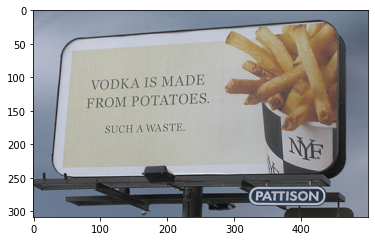

In [26]:
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/billboard.jpg'


image_file_name = basename(IMAGE_URL)
download_dir = '/content/drive/MyDrive/연대/YAI/2022산학협력/code/craft/CRAFT-pytorch/image_new'
!mkdir -p {download_dir} && rm -rf {download_dir}/*
!wget -q -P {download_dir} {IMAGE_URL}
  

plt.imshow(matplotlib.image.imread(join(download_dir, image_file_name)))

print(download_dir)

In [27]:
!cd "/content/drive/MyDrive/연대/YAI/2022산학협력/code/craft/CRAFT-pytorch" && python test.py --trained_model='/content/drive/MyDrive/연대/YAI/2022산학협력/code/craft/CRAFT-pytorch/craft_ic15_20k.pth' --test_folder='/content/drive/MyDrive/연대/YAI/2022산학협력/code/craft/CRAFT-pytorch/image_new'

Loading weights from checkpoint (/content/drive/MyDrive/연대/YAI/2022산학협력/code/craft/CRAFT-pytorch/craft_ic15_20k.pth)
elapsed time : 0.9206993579864502s


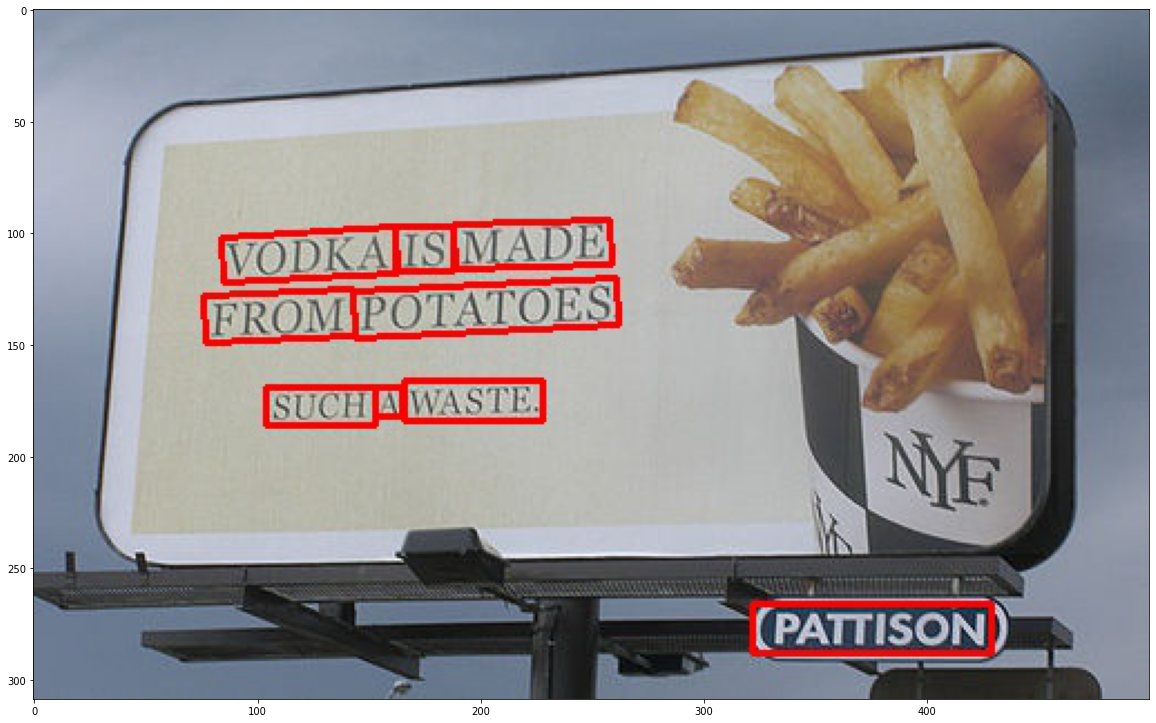

In [28]:
plt.figure(figsize=(20, 26))
plt.imshow(matplotlib.image.imread(join("/content/drive/MyDrive/연대/YAI/2022산학협력/code/craft/CRAFT-pytorch", 'result','res_'+image_file_name)))